In [ ]:
%%capture
try:
    import xclim
except ModuleNotFoundError:
    %pip install xclim
    import xclim

In [ ]:
import yaml
import warnings
import dask.distributed as dd
import gcsfs
import xarray as xr
import rhg_compute_tools.kubernetes as rhgk
import rhg_compute_tools.utils as rhgu

In [176]:
# downscale-cmip6 project pattern (IOWA - use with staging/impactlab & downscalecmip6 argo cluster)

ERA_0p25x0p25_NC_YEARLY_OUTPUT_PATTERN = 'gs://impactlab-data/climate/source_data/ERA-5/{variable_id}/daily/netcdf/v1.1/all_years_concatenated.zarr'

ERA_OUTPUT_PATTERN = 'gs://clean-f1e04ef5/reanalysis/ERA-5/F320/{variable_id}.1995-2015.F320.zarr'

CLEAN_OUTPUT_PATTERN = 'gs://clean-f1e04ef5/cmip6'

CLEAN_REGRIDDED_OUTPUT_PATTERN = 'gs://support-f8a48a9e/regrid-cmip6'

BC_OUTPUT_PATTERN = 'gs://biascorrected-4a21ed18/stage'

DC_OUTPUT_PATTERN = 'gs://downscaled-48ec31ab/outputs'


# onyx project pattern (Oregon - use with onyx clusters)
# OUTPUT_PATTERN = (
#     "gs://{CRS_SUPPORT_BUCKET}/internal_datasets/climate/CMIP6/gridded-climate-data/"
#     "R_CIL_GDPCIR-v{delivery_version}/{activity_id}/{institution_id}/{source_id}/"
#     "{experiment_id}/{member_id}/{table_id}/{variable_id}/{delivery_version}.zarr"
# )

ERA_DIAGNOSTICS_PATTERN = 'gs://downscaled-48ec31ab/diagnostics/RELEASE-{delivery_version}/{diagnostics_name}/reanalysis/ERA5/F320/{variable_id}/{delivery_version}.zarr'

ERA_0p25x0p25_NC_YEARLY_DIAGNOSTICS_PATTERN = 'gs://downscaled-48ec31ab/diagnostics/RELEASE-{delivery_version}/{diagnostics_name}/reanalysis/ERA5/0p25x0p25/{variable_id}/{delivery_version}.zarr'

DIAGNOSTICS_PATTERN = 'gs://downscaled-48ec31ab/diagnostics/RELEASE-{delivery_version}/{diagnostics_name}'

DEBUG_QUICK = False # skip dask cluster creation and any computation, just try to read data
DEBUG = False # compute but on a tiny portino of the data and don't write to storage
OVERWRITE = True # always write to storage even if diagnostics already exist
CHECK_IF_EXISTS = False # if already exists, checks what's inside
VARIABLE = 'tasmax'

N_WORKERS = 30 # number of dask workers

CITIES_COORDS_PATH = 'paper_data_cities_lat_lon_coordinates.yaml'

In [177]:
with open('data_paths.yaml', 'r') as f:
    DC6_PATHS = yaml.safe_load(f)

In [180]:
DELIVERY_VERSION = 'v1.1'

In [181]:
DELIVERY_MODELS = [
    'BCC-CSM2-MR',
    'FGOALS-g3',
    'ACCESS-ESM1-5',
    'ACCESS-CM2',
    'INM-CM4-8',
    'INM-CM5-0',
    'MIROC-ES2L',
    'MIROC6',
    'NorESM2-LM',
    'NorESM2-MM',
    'GFDL-ESM4',
    'GFDL-CM4',
    'NESM3',
    'CMCC-CM2-SR5',
    'CMCC-ESM2',
    'CanESM5',
    'MPI-ESM1-2-HR',
    'EC-Earth3',
    'EC-Earth3-AerChem',
    'EC-Earth3-Veg',
    'EC-Earth3-Veg-LR',
    'HadGEM3-GC31-LL',
    'UKESM1-0-LL',
    'MPI-ESM1-2-LR',
]

In [182]:
INSTITUTIONS = {    
    'BCC-CSM2-MR': 'BCC',
    'FGOALS-g3': 'CAS',
    'ACCESS-ESM1-5': 'CSIRO',
    'ACCESS-CM2': 'CSIRO-ARCCSS',
    'INM-CM4-8': 'INM',
    'INM-CM5-0': 'INM',
    'MIROC-ES2L': 'MIROC',
    'MIROC6': 'MIROC',
    'NorESM2-LM': 'NCC',
    'NorESM2-MM': 'NCC',
    'GFDL-ESM4': 'NOAA-GFDL',
    'GFDL-CM4': 'NOAA-GFDL',
    'NESM3': 'NUIST',
    'CMCC-CM2-SR5':'CMCC',
    'CMCC-ESM2':'CMCC',
    'MPI-ESM1-2-HR':'DKRZ',
    'EC-Earth3':'EC-Earth-Consortium',
    'EC-Earth3-AerChem':'EC-Earth-Consortium',
    'EC-Earth3-CC':'EC-Earth-Consortium',
    'EC-Earth3-Veg':'EC-Earth-Consortium',
    'EC-Earth3-Veg-LR':'EC-Earth-Consortium',
    'HadGEM3-GC31-LL':'MOHC',
    'UKESM1-0-LL':'MOHC',
    'MPI-ESM1-2-LR':'MPI-M',
    'CanESM5': 'CCCma',
}

In [183]:
ENSEMBLE_MEMBERS = {
    'BCC-CSM2-MR': 'r1i1p1f1',
    'FGOALS-g3': 'r1i1p1f1',
    'ACCESS-ESM1-5': 'r1i1p1f1',
    'ACCESS-CM2': 'r1i1p1f1',
    'INM-CM4-8': 'r1i1p1f1',
    'INM-CM5-0': 'r1i1p1f1',
    'MIROC-ES2L': 'r1i1p1f2',
    'MIROC6': 'r1i1p1f1',
    'NorESM2-LM': 'r1i1p1f1',
    'NorESM2-MM': 'r1i1p1f1',
    'GFDL-ESM4': 'r1i1p1f1',
    'GFDL-CM4': 'r1i1p1f1',
    'NESM3': 'r1i1p1f1',
    'CMCC-CM2-SR5':'r1i1p1f1',
    'CMCC-ESM2':'r1i1p1f1',
    'MPI-ESM1-2-HR':'r1i1p1f1',
    'EC-Earth3':'r1i1p1f1',
    'EC-Earth3-AerChem':'r1i1p1f1',
    'EC-Earth3-CC':'r1i1p1f1',
    'EC-Earth3-Veg':'r1i1p1f1',
    'EC-Earth3-Veg-LR':'r1i1p1f1',
    'HadGEM3-GC31-LL':'r1i1p1f3',
    'UKESM1-0-LL': 'r1i1p1f2',
    'MPI-ESM1-2-LR':'r1i1p1f1',
    'CanESM5': 'r1i1p1f1',
}

In [184]:
GRID_SPECS = {
    "ACCESS-CM2": "gn",
    "ACCESS-ESM1-5": "gn",
    "MIROC6": "gn",
    "EC-Earth3": "gr",
    "EC-Earth3-Veg-LR": "gr",
    "EC-Earth3-Veg": "gr",
    "CMCC-ESM2": "gn",
    "INM-CM5-0": "gr1",
    "INM-CM4-8": "gr1",
    "MIROC-ES2L": "gn",
    "FGOALS-g3": "gn",
    "BCC-CSM2-MR": "gn",
    "NorESM2-LM": "gn",
    "GFDL-ESM4": "gr1",
    "GFDL-CM4": "gr1",
    "NorESM2-MM": "gn",
    "NESM3": "gn",
    'CMCC-CM2-SR5':'gn',
    'MPI-ESM1-2-HR':'gn',
    'EC-Earth3-AerChem':'gr',
    'EC-Earth3-CC':'gr',
    'HadGEM3-GC31-LL':'gn',
    'UKESM1-0-LL': 'gn',
    'MPI-ESM1-2-LR':'gn',
    'CanESM5':'gn',
}

In [185]:
HIST_EXTENSION_SCENARIO = {
    "ACCESS-CM2": "ssp370",
    "MRI-ESM2-0": "ssp370",
    "ACCESS-ESM1-5": "ssp370",
    "MIROC6": "ssp370",
    "INM-CM5-0": "ssp370",
    "INM-CM4-8": "ssp370",
    "MIROC-ES2L": "ssp370",
    "FGOALS-g3": "ssp370",
    "BCC-CSM2-MR": "ssp370",
    "AWI-CM-1-1-MR": "ssp370",
    "NorESM2-LM": "ssp370",
    "GFDL-ESM4": "ssp370",
    "GFDL-CM4": "ssp245",
    "CAMS-CSM1-0": "ssp370",
    "NorESM2-MM": "ssp370",
    "NESM3": "ssp245",
    'CMCC-CM2-SR5':"ssp370",
    'CMCC-ESM2':"ssp370",
    'CanESM5':"ssp370",
    'MPI-ESM1-2-HR':"ssp126",
    'EC-Earth3':"ssp370",
    'EC-Earth3-AerChem':"ssp370",
    'EC-Earth3-CC':"ssp245",
    'EC-Earth3-Veg':"ssp370",
    'EC-Earth3-Veg-LR':"ssp370",
    'HadGEM3-GC31-LL':"ssp245",
    'UKESM1-0-LL':"ssp370",
    'MPI-ESM1-2-LR':"ssp370",
}

In [ ]:
if not DEBUG_QUICK:
    client, cluster = rhgk.get_giant_cluster(extra_pip_packages='xclim')
    cluster.scale(N_WORKERS)
    cluster
    print('https://jhub-dev.onyx.climateriskservice.com' + cluster.dashboard_link)
    # wait until the workers come online - otherwise we get unbalanced task loading and things start acting all fishy
    import time
    while len(client.ncores()) < N_WORKERS:
        time.sleep(5)
    import dask
    dask.config.set(**{'array.slicing.split_large_chunks': False})

In [186]:
def get_fp(model, scenario, variable, diagnostics_type):

    fs = gcsfs.GCSFileSystem(
        timeout=120,
        cache_timeout=120,
        requests_timeout=120,
        read_timeout=120,
        conn_timeout=120,
    )
    
    if model == 'ERA5':
        fp = ERA_OUTPUT_PATTERN.format(variable_id=variable)
        diagnostics_fp = ERA_DIAGNOSTICS_PATTERN.format(variable_id=variable,
                                                        delivery_version=DELIVERY_VERSION,
                                                        diagnostics_name=diagnostics_type)
    elif model == 'ERA5_0p25x0p25':
        fp = ERA_0p25x0p25_NC_YEARLY_OUTPUT_PATTERN.format(variable_id=variable)
        diagnostics_fp = ERA_0p25x0p25_NC_YEARLY_DIAGNOSTICS_PATTERN.format(variable_id=variable,
                                                        delivery_version=DELIVERY_VERSION,
                                                        diagnostics_name=diagnostics_type)
    else:
        paths = DC6_PATHS[f"{model}-{variable}"][scenario]
        
        if scenario == 'historical':
            activity_id = 'CMIP'
        else:
            activity_id = 'ScenarioMIP'
            
        diagnostics_root = DIAGNOSTICS_PATTERN.format(diagnostics_name=diagnostics_type,
                                                      delivery_version=DELIVERY_VERSION
                                                     )
        if 'biascorrected' in diagnostics_type:
            fp = paths['biascorrected']
            diagnostics_fp = fp.replace(BC_DIAGNOSTICS_PATTERN, diagnostics_root)
        elif 'clean-regridded-1deg' in diagnostics_type:
            fp = paths['clean_regridded']
            diagnostics_fp = fp.replace(CLEAN_REGRIDDED_OUTPUT_PATTERN, diagnostics_root)
        elif 'clean' in diagnostics_type:
            fp = paths['clean']
            diagnostics_fp = fp.replace(CLEAN_OUTPUT_PATTERN, diagnostics_root)
        else:
            fp = paths['downscaled_delivered']
            diagnostics_fp = fp.replace(DC_OUTPUT_PATTERN, diagnostics_root)
    
    return fp, diagnostics_fp, fs

In [187]:
# def process_ERA_regridded(fs, fps_in, variable, lightweight=True):
#     var_parser = {
#         "pr": "precip_total",
#         "tasmin": "tmin",
#         "tasmax": "tmax",
#     }
#     converter = {
#         "longitude": "lon",
#         "latitude": "lat",
#         var_parser[variable]: variable,
#     }
#     if lightweight:
#         fps_in = fps_in[:2]
#     i = 0
#     for fp in fps_in:
#         print(f"processing {fp}")
#         try:
#             if i == 0:  # primer
#                 print('primer')
#                 with xr.open_dataset(fs.open(fp)) as ds:
#                     lats_lons = get_latlon_to_citynames()
#                     print('sel')
#                     primer = ds.sel(
#                         latitude=xr.DataArray(list(lats_lons[0].values()), dims="latitude"),
#                         longitude=xr.DataArray(list(lats_lons[1].values()), dims="longitude"),
#                         method="nearest",
#                         drop=False,
#                     )
#                     print('vals')
#                     vals = primer[var_parser[variable]].values
#                     print('time')
#                     times= primer['time'].values

#             else:
#                 with xr.open_dataset(fs.open(fp)) as ds:
#                     print('concat')
#                     print('sel')
#                     ds_sel = ds.sel(
#                         latitude=xr.DataArray(list(lats_lons[0].values()), dims="latitude"),
#                         longitude=xr.DataArray(list(lats_lons[1].values()), dims="longitude"),
#                         method="nearest",
#                         drop=False,
#                     )
#                     print('vals concat')
#                     vals = np.concatenate([vals,ds_sel[var_parser[variable]].values], 0)
#                     print('times concat')
#                     times = np.concatenate([times,ds_sel['time'].values])
#         except Exception as e:
#             warnings.warn(f"encountered an error processing {fp}")
#             raise
#         i = i + 1
#     out_da = xr.DataArray(data=vals, dims=['time', 'lat', 'lon'], coords={'time':times, 'lat':primer['latitude'].values, 'lon':primer['longitude'].values})
#     out_ds = xr.Dataset({variable : out_da})
#     out_ds.attrs[
#         "source"
#     ] = "yearly files of ERA-5 daily data created from /gcs/impactlab-data/climate/source_data/ERA-5/day/precip_total/v1.1/intermediate, written to netcdf files for each year and then concatenated to a single zarr file"
#     out_ds.attrs["author"] = "Emile Tenezakis"
#     out_ds.attrs["contact"] = "e.tenezakis@gmail.com"
#     out_ds.attrs["project"] = "CMIP6 downscaling"
#     out_ds.attrs["created"] = "2022-03-18"
#     return out_ds

In [188]:
def read_data(model, scenario, variable, diagnostic_type, overwrite, isel_slices=None, chunks=None, check_if_exists=False):
    
    fp, diagnostics_fp, fs = get_fp(model, scenario, variable, diagnostic_type)

    print(fp)
    if fs.exists(diagnostics_fp) and not overwrite:
        if check_if_exists:
            if chunks is None:
                ds = xr.open_zarr(fs.get_mapper(fp))
            else:
                ds = xr.open_zarr(fs.get_mapper(fp), chunks=chunks)
            min = ds[variable].min.compute()
            max = ds[variable].max.compute()
            if min.values.item()==0 and max.values.item()==0:
                warnings.warn(f"invalid diagnostics file already existing : {diagnostics_fp}")
                return "output path exists already but invalid"
        return "output path exists already"
    if not fs.exists(fp):
        return "input path does not exist"

    mapper = fs.get_mapper(fp)

    if chunks is None:
        ds = xr.open_zarr(mapper)
    else:
        ds = xr.open_zarr(mapper, chunks=chunks)

    if isel_slices is not None:
        ds = ds.isel(isel_slices, drop=False)

    return ds, fs, diagnostics_fp

In [189]:
def get_latlon_to_citynames():
    
    with open(CITIES_COORDS_PATH, 'r') as f:
        cities_coords = yaml.safe_load(f) 
    
    lats = cities_coords['lats']
    lons = cities_coords['lons']
    
    return lats, lons
    
# got it that way : 
#     lats = {}
#     lons = {}
#     geolocator = Nominatim(user_agent="whatever")
#     cities = ['Tokyo', 'Delhi', 'Shanghai' , 'Sao Paulo', 'Mexico City',
#               'Cairo', 'Dhaka', 'New York', 'Buenos Aires', 'Istanbul',
#               'Lagos', 'Paris', 'Moscow', 'Miami', 'Mumbai', 'Manila', 'London']
#     for c in cities:
#         location = geolocator.geocode(c) 
#         lats[c] = location.latitude
#         lons[c] = location.longitude

#     return lats, lons

In [190]:
@rhgu.block_globals(whitelist=[
    'DIAGNOSTICS_PATTERN',
    'OUTPUT_PATTERN',
    'DELIVERY_VERSION',
    'DELIVERY_MODELS',
    'INSTITUTIONS',
    'ENSEMBLE_MEMBERS',
    'GRID_SPECS',
    'HIST_EXTENSION_SCENARIO',
])
def diagnostics(model, scenario, diagnostics_type, variable, overwrite=OVERWRITE, debug=DEBUG):
    
    
    
    isel_slices = None
    if debug and 'daily' not in diagnostics_type:
        isel_slices = {'lat': slice(0,2), 'lon': slice(0,2)}
    
    if (('biascorrected' in diagnostics_type) or ('clean-regridded-1deg' in diagnostics_type)):
        if variable=='pr':
            new_chunks = {'time': 365, 'lat': 360, 'lon': 360}
        else:
            new_chunks = {'time': 365, 'lat': 360, 'lon': 360}
    else:
        new_chunks = None
        
    i_o = read_data(model, scenario, variable, diagnostics_type, overwrite, isel_slices, chunks=new_chunks)
    
    if isinstance(i_o, str):
        warnings.warn(f'Skipping. {i_o} : {model}, {scenario}, {diagnostics_type}, {variable}')
        return
    else:
        print(f'Will produce diagnostics for : {model}, {scenario}, {diagnostics_type}, {variable}')
        ds, fs, out = i_o
        
    
    if 'daily' in diagnostics_type:
        lats, lons = get_latlon_to_citynames()
        summary = ds.sel(lat=xr.DataArray(list(lats.values()), dims='city', coords={"city":list(lats.keys())}), 
                lon=xr.DataArray(list(lons.values()), dims='city', coords={"city":list(lats.keys())}), 
                method='nearest')
        summary.chunk({'time': 365})
    elif 'annual-tasmax-diagnostics' in diagnostics_type :   
        client = dd.get_client()
        average = ds.groupby('time.year').mean()
        count_hot = ds.where(ds > 308.15).groupby('time.year').count() # > 95F, in Kelvin
        average, count_hot = client.compute(
            [average, count_hot],
            sync=True,
            optimize_graph=True,
            retries=3,
        )
        summary = xr.Dataset({
            'annual_average_tasmax': average['tasmax'],
            'annual_count_above_95F': count_hot['tasmax'],
        })
        summary['annual_average_tasmax'].attrs.update({
            'long_name': 'annual_average_tasmax',
            'units': 'Kelvin',
            'description': 'Annual average maximum daily temperature',
            'cell_method': "ds.groupby('time.year').mean()",
        })
        summary['annual_count_above_95F'].attrs.update({
            'long_name': 'annual_count_above_95F',
            'units': 'day count',
            'description': 'Annual count of days with maximum temperature above 308.15 Kelvin = 95F.',
            'cell_method': "ds.where(ds > 308.15).groupby('time.year').sum()",
        })    
        summary.attrs.update(ds.attrs)
        summary.chunk({'year': 5})  
    elif 'annual-precip-diagnostics' in diagnostics_type:
        client = dd.get_client()
        cdd = ds.pr.map_blocks(xclim.indicators.icclim.CDD, template=ds.pr.resample(time='YS').count())
        max_5day_precip = ds.pr.rolling(time=5, center=True).sum().resample(time='YS').max()
        total_seasonal_precip = ds.pr.resample(time='3MS').sum()
        total_annual_precip = total_seasonal_precip.resample(time='YS').sum()

        cdd, max_5day_precip, total_seasonal_precip, total_annual_precip = client.compute(
            [cdd, max_5day_precip, total_seasonal_precip, total_annual_precip],
            sync=True,
            optimize_graph=True,
            retries=3,
        )

        cdd = cdd.assign_coords(time=cdd.time.dt.year).rename({'time': 'year'})
        max_5day_precip = max_5day_precip.assign_coords(time=max_5day_precip.time.dt.year).rename({'time': 'year'})
        total_annual_precip = total_annual_precip.assign_coords(time=total_annual_precip.time.dt.year).rename({'time': 'year'})

#         cdd = xclim.indicators.atmos.maximum_consecutive_dry_days(ds['pr'])
#         # this is buggy
#         #cdd = ds.pr.map_blocks(xclim.indicators.icclim.CDD, template=ds.pr.resample(time='YS').count())
#         max_5day_precip = ds.pr.rolling(time=5, center=True).sum().resample(time='YS').max()
#         total_seasonal_precip = ds.pr.resample(time='3MS').sum()
#         total_annual_precip = total_seasonal_precip.resample(time='YS').sum()
#         # this is buggy 
#         # cdd, max_5day_precip, total_seasonal_precip, total_annual_precip = client.compute(
#         #     [cdd, max_5day_precip, total_seasonal_precip, total_annual_precip],
#         #     sync=True,
#         #     optimize_graph=True,
#         #     retries=3,
#         # )
#         cdd = cdd.compute()
#         max_5day_precip = max_5day_precip.compute()
#         total_seasonal_precip = total_seasonal_precip.compute()
#         total_annual_precip = total_annual_precip.compute()
#         cdd = cdd.assign_coords(time=cdd.time.dt.year).rename({'time': 'year'})
#         max_5day_precip = max_5day_precip.assign_coords(time=max_5day_precip.time.dt.year).rename({'time': 'year'})
#         total_annual_precip = total_annual_precip.assign_coords(time=total_annual_precip.time.dt.year).rename({'time': 'year'})

        summary = xr.Dataset({
            'cdd': cdd,
            'max_5day_precip': max_5day_precip,
            'total_seasonal_precip': total_seasonal_precip,
            'total_annual_precip': total_annual_precip,
        })
        summary['cdd'].attrs.update({
            'long_name': 'Maximum annual dry day count',
            'units': 'day count',
            'description': 'Maximum annual count of continuous dry days',
            'cell_method': "xclim.indicators.icclim.CDD",
        })
        summary['max_5day_precip'].attrs.update({
            'long_name': 'max_5day_precip',
            'units': 'mm/day',
            'description': 'Maximum annual 5-day cumulative surface precipitation',
            'cell_method': "ds.pr.rolling(time=5, center=True).sum().resample(time='YS').max()",
        })
        summary['total_seasonal_precip'].attrs.update({
            'long_name': 'total_seasonal_precip',
            'units': 'mm/day',
            'description': 'Cumulative seasonal surface precipitation',
            'cell_method': "ds.pr.resample(time='3MS').sum()",
        })
        summary['total_annual_precip'].attrs.update({
            'long_name': 'total_annual_precip',
            'units': 'mm/day',
            'description': 'Cumulative annual surface precipitation',
            'cell_method': "total_seasonal_precip.resample(time='YS').sum()",
        })
        summary.attrs.update(ds.attrs)
        summary.chunk({'year': 5, 'time': 20})
    elif 'annual-tasmin-diagnostics' in diagnostics_type:   
        client = dd.get_client()
        average = ds.groupby('time.year').mean()
        average = client.compute(
            average,
            sync=True,
            optimize_graph=True,
            retries=3,
        )
        summary = xr.Dataset({
            'annual_average_tasmin': average['tasmin']
        })
        summary['annual_average_tasmin'].attrs.update({
            'long_name': 'annual_average_tasmin',
            'units': 'Kelvin',
            'description': 'Annual average minimum daily temperature',
            'cell_method': "ds.groupby('time.year').mean()",
        })
        summary.attrs.update(ds.attrs)
        summary.chunk({'year': 5})
    else:
        raise ValueError('unknown diagnostic type')
        
    if debug:
        return summary
    else: 
        print(out)
        summary.to_zarr(fs.get_mapper(out), consolidated=True, mode='w')

In [191]:
def parse_var(variable):
    if variable=='pr':
        return 'precip'
    else:
        return variable

In [192]:
%%time
try:
#     with tqdm(DELIVERY_MODELS) as pbar:
#         for m in pbar:
#             scens = list(DC6_PATHS[f'{m}-{VARIABLE}'].keys())
#             parsed_var = parse_var(VARIABLE)
#             for s in ['historical']:
#                 pbar.set_postfix({'model': m, 'scenario': s})
#                 diagnostics(model=m, scenario=s, diagnostics_type=f'annual-{parsed_var}-diagnostics', variable=VARIABLE) 
#                 diagnostics(model=m, scenario=s, diagnostics_type=f'daily-{parsed_var}-diagnostics', variable=VARIABLE)
    diagnostics(model='ERA5_0p25x0p25', scenario='historical', diagnostics_type=f'daily-{parse_var(VARIABLE)}-diagnostics', variable=VARIABLE)
    
except Exception:
#     if not DEBUG_QUICK:
#         client.close()
#         cluster.close()
    raise

gs://impactlab-data/climate/source_data/ERA-5/tasmax/daily/netcdf/v1.1/all_years_concatenated.zarr
Will produce diagnostics for : ERA5_0p25x0p25, historical, daily-tasmax-diagnostics, tasmax
gs://downscaled-288ec5ac/diagnostics/RELEASE-v1.1/daily-tasmax-diagnostics/reanalysis/ERA5/0p25x0p25/tasmax/v1.1.zarr
CPU times: user 8.48 s, sys: 903 ms, total: 9.38 s
Wall time: 20.1 s


In [204]:
ds = xr.open_zarr(fs.get_mapper('gs://downscaled-48ec31ab/diagnostics/RELEASE-v1.1/daily-precip-diagnostics/reanalysis/ERA5/0p25x0p25/pr/v1.1.zarr'))

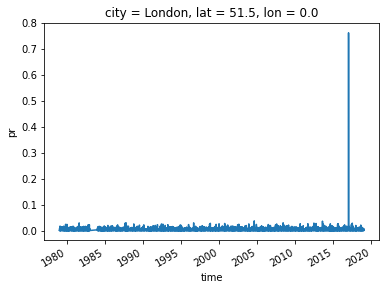

In [206]:
da = ds['pr'].sel(city='London').plot()

In [195]:
da.where(da>0.7, drop=True)

<xarray.DataArray 'pr' (time: 4)>
dask.array<where, shape=(4,), dtype=float64, chunksize=(4,), chunktype=numpy.ndarray>
Coordinates:
    city     <U12 'London'
    lat      float32 dask.array<chunksize=(), meta=np.ndarray>
    lon      float32 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) datetime64[ns] 2016-12-28 2016-12-29 2016-12-30 2016-12-31

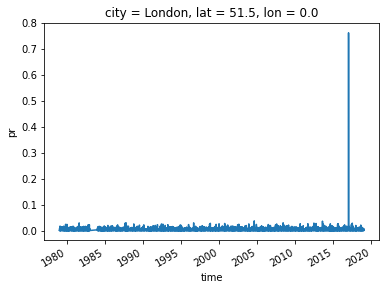

In [196]:
da.plot()

In [ ]:
ds.mean().compute()

In [211]:
if not DEBUG_QUICK:
    client.close()
    cluster.close()

In [210]:
import dask_gateway
gateway = dask_gateway.Gateway()
gateway.list_clusters()

[]